# Group_125_Assignment_2_Question_5 : Image Captioning

**Image Captioning** : Image Captioning is the process of generating textual description of an image. It uses
both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image
→ captions]. The dataset consists of input images and their corresponding output captions.

**Encoder**:
The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract
the features. The last hidden state of the CNN is connected to the Decoder.

Decoder:
The Decoder is a Recurrent Neural Network(RNN) which does language modelling up to the word level. The first time
step receives the encoded output from the encoder and also the <START> vector.

##1. Import Libraries/Dataset (0 mark)

### a. Import the required libraries

In [ ]:
import pandas as pd
import string
import numpy as np
from numpy import array
import pickle
from pickle import dump, load
import tensorflow as tf
from google.colab import drive
import os
import string
import pathlib
from time import time
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.models import load_model
from tensorflow.keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [ ]:
!nvidia-smi

Sun Aug  8 13:39:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  14528MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Data Visualization and augmentation (3 mark)

Read the pickle file (https://drive.google.com/file/d/1pcFPrRGGk0kEzLXlfIDrAvRZbTBiVeET/view?usp=sharing) and
convert the data into the correct format which could be used for ML model.
Pickle file contains the image id and the text associated with the image.

Eg: '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .
Each image can have multiple captions.
319847657_2c40e14113.jpg -> image name

0 -> Caption ID

\t -> separator between Image name and Image Caption

A girl in a purple shirt hold a pillow . -> Image Caption

Corresponding image wrt image name can be found in the image dataset folder.

In [ ]:
drive.mount('/content/drive',force_remount=True)
PATH =  '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/'
file_name = "set_0.pkl"
path_to_embed = os.path.join(PATH, file_name)
print(path_to_embed)
file = pickle.load(open(path_to_embed, "rb"))

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/set_0.pkl


In [ ]:
len(file)

25000

In [ ]:
# Conversion of List to Dictionary
descriptions ={}
for caption in file[:-1]:
  #print(caption)
  img, caption = caption.split('\t')
  if img[:-2] not in descriptions:
    descriptions[img[:-2]] = [ caption ]
  else:
    descriptions[img[:-2]].append(caption)
print(descriptions) 
print(type(descriptions))

{'318667317_108c402140.jpg': ['A man in a black hoodie be hold a paper sign .', 'A homeless man carry a sign that say " hungry " .', 'A bearded man hold a sign .', 'A man in a black hoodie hold a small sign .'], '2072574835_febf0c5fb9.jpg': ['Three race dog be run out of the start gate on a track .', 'Greyhound dog wear race stripe be run out of a gate on a track .', 'Dog in a race .'], '3083016677_5782bc337c.jpg': ['Two motorcycle with two rider each .', 'There be two motorcycle with a man and a woman on it .', 'Two guy with helmet be on motorcycle , each with a woman ride behind him', 'Two motorcycle and four rider be on a road .'], '95734038_2ab5783da7.jpg': ['A man on a bike nest to a river .', 'A man ride a bicycle on a rocky path beside a lake in the mountain .', 'A man stand astride a bike on a rocky trail by a lake .'], '241346146_f27759296d.jpg': ['A football player try tackle another player who have the ball .', 'A Sooner football player carry the ball be try to avoid be tack

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
df = pd.DataFrame.from_dict(descriptions, orient='index', columns=['Caption-1', 'Caption-2', 'Caption-3', 'Caption-4','Caption-5'])
df = df.reset_index()
df = df.rename(columns={"index": "fileName"})

In [ ]:
df.head()

,fileName,Caption-1,Caption-2,Caption-3,Caption-4,Caption-5
0,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .,"A homeless man carry a sign that say "" hungry "" .",A bearded man hold a sign .,A man in a black hoodie hold a small sign .,None
1,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...,Greyhound dog wear race stripe be run out of a...,Dog in a race .,None,None
2,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .,There be two motorcycle with a man and a woman...,"Two guy with helmet be on motorcycle , each wi...",Two motorcycle and four rider be on a road .,None
3,95734038_2ab5783da7.jpg,A man on a bike nest to a river .,A man ride a bicycle on a rocky path beside a ...,A man stand astride a bike on a rocky trail by...,None,None
4,241346146_f27759296d.jpg,A football player try tackle another player wh...,A Sooner football player carry the ball be try...,A football player be run with the ball as a pl...,None,None


In [ ]:
# cleaning_text( descriptions) – This function takes all descriptions and performs data cleaning. This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers.
#So, a caption like “A man riding on a three-wheeled wheelchair” will be transformed into “man riding on three wheeled wheelchair”
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions
    
clean_descriptions = cleaning_text(descriptions)

In [ ]:
list(clean_descriptions.items())[0]

('318667317_108c402140.jpg',
 ['man in black hoodie be hold paper sign',
  'homeless man carry sign that say hungry',
  'bearded man hold sign',
  'man in black hoodie hold small sign'])

In [ ]:
# text_vocabulary( descriptions ) – This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions.
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  5490


In [ ]:
# save_descriptions( descriptions, filename ) – This function will create a list of all the descriptions that have been preprocessed and store them into a file. We will create a descriptions.txt file to store all the captions. It will look something like this:

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

**Read the Image Dataset folder**

In [ ]:
image_path = os.path.join(PATH, 'Flicker8k_Dataset')

print(image_path)
data_dir = pathlib.Path(image_path)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)


/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset
8102



### a. Plot at least two samples and their captions (use matplotlib/seaborn/any other library).

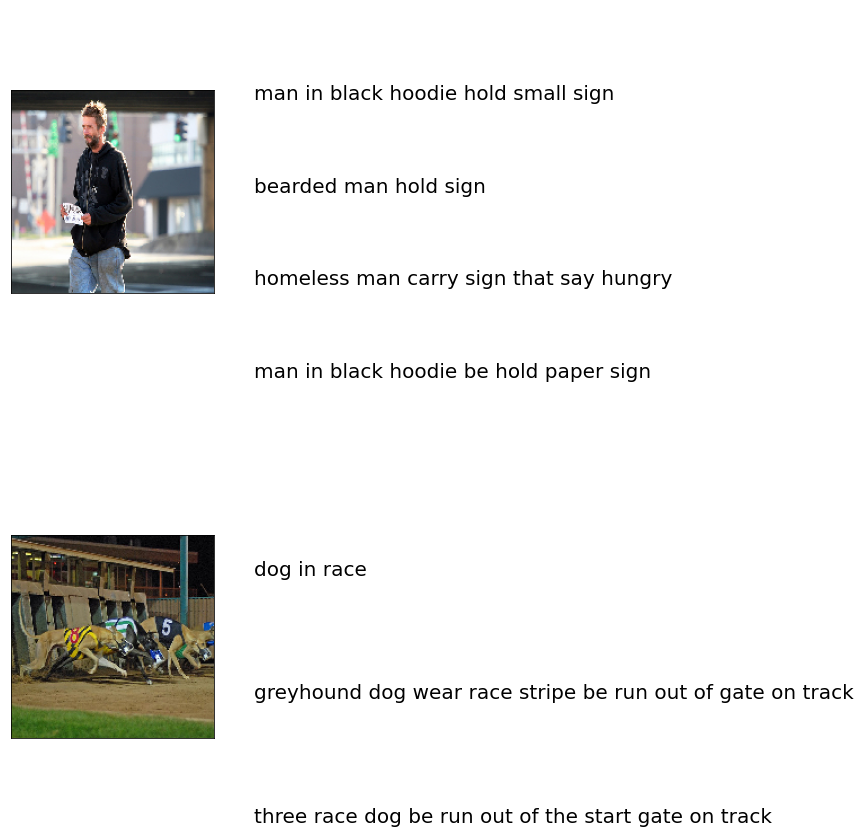

In [ ]:
#Picking initial 2 sample files from dataset and displaying them with their captions
npic = 2
height = 180
width = 180


target_size = (width,height,3)
count = 1
list_imageFileName = df['fileName']
fig = plt.figure(figsize=(8,15))
for jpgfnm in list_imageFileName[0:2]:
   filename = image_path + '/' + jpgfnm
   captions = list(clean_descriptions[jpgfnm])
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

### b. Bring the train and test data in the required format.

In [ ]:
#Creating single dataframe and arranging data based on file name
output = pd.DataFrame()
fileNames = []
captions_List = []
for key, values in clean_descriptions.items():
  for index, caption in enumerate(values):
    fileNames.append(key)
    captions_List.append(caption)
  
output['fileName'] = fileNames
output['captions'] = captions_List
output = output.reset_index()
output

,index,fileName,captions
0,0,318667317_108c402140.jpg,man in black hoodie be hold paper sign
1,1,318667317_108c402140.jpg,homeless man carry sign that say hungry
2,2,318667317_108c402140.jpg,bearded man hold sign
3,3,318667317_108c402140.jpg,man in black hoodie hold small sign
4,4,2072574835_febf0c5fb9.jpg,three race dog be run out of the start gate on...
...,...,...,...
24994,24994,2286032269_8ba929709c.jpg,boy be surf
24995,24995,524105255_b346f288be.jpg,blond girl pose for picture at kerry park in s...
24996,24996,524105255_b346f288be.jpg,woman look at view of city
24997,24997,3599124739_b7e60cf477.jpg,two girl play in the surf


**Cleaning the dataset**

In [ ]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
import re
def invalid_filename_check(data):
  for filenames in data["fileName"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

invalid_filename_check(output)

**Note: -** Since we can now view that some invalid data is also present, so we are removing invalid data from dataset.

In [ ]:
output[output['fileName'] == "2258277193_586949ec62.jpg.1"]

,index,fileName,captions


In [ ]:
output = output[output['fileName'] != '2258277193_586949ec62.jpg.1']
output.shape

(24995, 3)

In [ ]:
#Preprocess Images from their actual path
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["fileName"]:
      full_image_path = image_path+"/"+ filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector
all_img_name_vector = preprocess_images(output)
all_img_name_vector[:10]

['/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/318667317_108c402140.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/318667317_108c402140.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/318667317_108c402140.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/318667317_108c402140.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/2072574835_febf0c5fb9.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/2072574835_febf0c5fb9.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/2072574835_febf0c5fb9.jpg',
 '/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/Flicker8k_Dataset/3083016677_5782bc337c.jpg',
 '/content/drive/My Drive/Co

In [ ]:
#Preprocess Captions
def preprocess_captions(data):
  total_captions = []

  for caption  in data["captions"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(output)
total_captions[:10]

['<start> man in black hoodie be hold paper sign <end>',
 '<start> homeless man carry sign that say hungry <end>',
 '<start> bearded man hold sign <end>',
 '<start> man in black hoodie hold small sign <end>',
 '<start> three race dog be run out of the start gate on track <end>',
 '<start> greyhound dog wear race stripe be run out of gate on track <end>',
 '<start> dog in race <end>',
 '<start> two motorcycle with two rider each <end>',
 '<start> there be two motorcycle with man and woman on it <end>',
 '<start> two guy with helmet be on motorcycle each with woman ride behind him <end>']

In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [ ]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 24995 , Total images = 24995


In [ ]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [ ]:
train_seqs[:3] # Here we can see that the sentences are converted to sequences

[[2, 10, 23, 240, 91, 40, 39, 189, 3],
 [2, 167, 17, 5, 44, 6, 149, 9, 170, 12, 122, 3],
 [2, 155, 8, 21, 38, 7, 333, 3]]

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [ ]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 31 : 2


In [ ]:
## Pad each vector to max length so that - captions are of equal length
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector

In [ ]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(24995, 31)


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

In [ ]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [ ]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 19996,Y = 19996
Test Data : X = 4999,Y = 4999


##3. Model Building (7 mark)

### a. Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.

Normally, the CNN's last layer is the softmax layer, which assigns the probability that each object might be in the image. But, if we remove that softmax layer from CNN, we can feed the CNN's rich encoding of the image into the DECODER(language generation of RNN) designed to produce phrases. We can then train the whole system directly on images and their captions, so it maximizes the likelihood that the descriptions it produces best match the training descriptions for each image

In [ ]:
modelvgg = tf.keras.applications.VGG16(include_top=True,weights='imagenet')
modelvgg.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

## a. Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.

**We are using `Transfer Learning` here from VGG16 model. However we have droppend the `prediction` layer of VGG16 model and will use its rest of the layers for `image feature extraction`**

In [ ]:
# extract features from each photo in the directory
def extract_features(image_Path_Directory):
    # load the model
    model_test = VGG16()
    
    # re-structure the model
    model_test = Model(inputs=model_test.inputs, outputs=model_test.layers[-2].output)
    
    # summarize
    print(model_test.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_Path_Directory:
        
        # load an image from file
        filename = name
        # image_Path_Directory
        # directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model_test.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature

    return features

Extracting image features for train_validate_images - Training Dataset

**Note: -** We have run it once only since it takes long time, thus after running we hvw saved extracted image features in a .pkl file in the same folder.

In [ ]:
train_validate_features = extract_features(img_name_train)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
len(train_validate_features)

7813

Saving extracted image features in .pkl file

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/encoded_train_images_new.pkl", "wb") as encoded_pickle:
    pickle.dump(train_validate_features, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/encoded_train_images_new.pkl", "rb"))
print('Photos: test=%d' % len(train_features))

Photos: test=7813


In [ ]:
train_validate_features = train_features

Extracting image features for test_validate_images - Test Dataset

**Note: -** We have run it once only since it takes long time, thus after running we hvw saved extracted image features in a .pkl file in the same folder.

In [ ]:
# extracting image features for train_validate_images
test_validate_features = extract_features(img_name_test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/encoded_test_images_new.pkl", "wb") as encoded_pickle:
    pickle.dump(test_validate_features, encoded_pickle)

In [ ]:
test_features = load(open("/content/drive/My Drive/Colab Notebooks/Group_125_Assignment_2_Question_5/encoded_test_images_new.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=3904


In [ ]:
test_validate_features = test_features

In [ ]:
# clean the captions
# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, listOfCaptions in clean_descriptions.items():
  for caption_text in listOfCaptions:
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
  image_With_path = PATH + 'Flicker8k_Dataset/' + image

  image_Without_Extension = image_With_path.split('.')[0]
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
  if image_With_path in img_name_train and image_Without_Extension in list(train_validate_features.keys()):
    train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

7813

In [ ]:
# make a dictionary of image with caption for test_validate_images
test_validate_image_caption = {}

for image, caption in new_captions_dict.items():
  image_With_path = PATH + 'Flicker8k_Dataset/' + image

  image_Without_Extension = image_With_path.split('.')[0]
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
  if image_With_path in img_name_test and image_Without_Extension in list(test_validate_features.keys()):
    test_validate_image_caption.update({image : caption})

len(test_validate_image_caption)

3904

**Preparing dataset of image and caption for model by processing them and binding togther.**

In [ ]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:
        fileName = os.path.basename(image)
        fileName = fileName + '.jpg'
        # store the caption of that image
        caption = train_validate_image_caption[fileName]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
fileNames_Train = list(train_validate_features.keys())

In [ ]:
train_x1, train_x2, train_y = prepare_data(fileNames_Train[0:6251])
validate_x1, validate_x2, validate_y = prepare_data( fileNames_Train[6251:])

In [ ]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)


shape of train_x1  (62745, 4096)
shape of train_x2  (62745, 30)
shape of train_y  (62745, 3410)

shape of validate_x1  (15723, 4096)
shape of validate_x2  (15723, 30)
shape of validate_y  (15723, 3410)


### b. Create 3 layered LSTM layer model and other relevant layers for image caption generation.


### c. Add L2 regularization to all the LSTM layers.


### d. Add one layer of dropout at the appropriate position and give reasons.


### e. Choose the appropriate activation function for all the layers.

In [ ]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(droplayer_)
lstm_two = LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(lstm)
lstm_three = LSTM(256, kernel_regularizer=regularizers.l2(0.01))(lstm_two)

# decoder model
decoder1 = add([denselayer, lstm_three])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)

In case of position change of dropout layer (keeping dropout value same as 0.50) between dense layers having less parameters, causes to drop less neurons which in turn makes the model perform better only in case of training data.

Thus, we can say dropout layer at the above positions is preventing model from overfitting.

### f. Print the model summary.

In [ ]:
# summarize model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      872960      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
______________________________________________________________________________________________

## 4. Model Compilation (1 mark)

### a. Compile the model with the appropriate loss function.
### b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

**Reason** - Rationale behind learning rate: Small value of learning rate helps algorithm converge slowly, however, finds the optimum solution with possible global minima. It's standard practice to use small value of learning rate starting with 0.001

Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient.


## 5. Model Training (1 mark)


In [ ]:
# custom callback creates to fetch the time of training model
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

In [ ]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss'),
             cb]

### a. Train the model for an appropriate number of epochs. 

In [ ]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 10, 
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y)) 

Epoch 1/10
1961/1961 [==============================] - 550s 266ms/step - loss: 6.1407 - val_loss: 5.0779
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1961/1961 [==============================] - 510s 260ms/step - loss: 4.8805 - val_loss: 5.0492
Epoch 3/10
1961/1961 [==============================] - 505s 257ms/step - loss: 4.7396 - val_loss: 5.0581
Epoch 4/10
1961/1961 [==============================] - 501s 255ms/step - loss: 4.6503 - val_loss: 5.1052
Epoch 5/10
1961/1961 [==============================] - 501s 256ms/step - loss: 4.5814 - val_loss: 5.1406
Epoch 6/10
1961/1961 [==============================] - 503s 257ms/step - loss: 4.5281 - val_loss: 5.2123
Epoch 7/10
1961/1961 [==============================] - 508s 259ms/step - loss: 4.5076 - val_loss: 5.2861
Epoch 8/10
1961/1961 [==============================] - 505s 257ms/step - loss: 4.4555 - val_loss: 5.3485
Epoch 9/10
1961/1961 [==============================] - 506s 258ms/step - loss: 4.4307 - val_loss: 5.4394
Epoch 10/10
1961/1961 [==============================] - 514s 262ms/step - loss: 4.4123 - val_loss: 5.4628


In [ ]:
model.save('./latest_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Print the train and validation loss for each epoch. Use the appropriate batch size.

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training loss \t', history.history['val_loss'][-1])

Final training loss 	 4.42437219619751
Final training loss 	 5.462773323059082


### b. Plot the loss and accuracy history graphs for both train and validation set. 

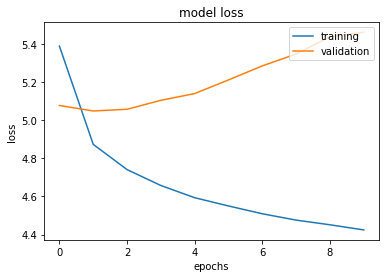

In [ ]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Print the total time taken for training.

In [ ]:
print("Total time taken for training -")
#Total time taken by model to train (in seconds)
print(sum(cb.logs))
print("\n")
#Time taken by each Epoch (in seconds)
print("Total time taken by each epoch during training -")
print(cb.logs)

Total time taken for training -
0


Total time taken by each epoch during training -
[]


## 6. Model Evaluation (1 mark)
### a. Take a random image from google and generate caption for that image.

In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model_validation = VGG16()
    # re-structure the model
    model_validation = tf.keras.Model(model_validation.inputs, model_validation.get_layer('fc1').output)
    #  Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model_validation.predict(image, verbose=0)
    return feature

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for val in train_captions:
    # for cap in val:
        all_train_captions.append(val)
len(all_train_captions)

24995

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 5493 -> 1233


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
embedding_dim = 200

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

True
Predicted caption ->  startseq man in in in and endseq

*********************************************************************


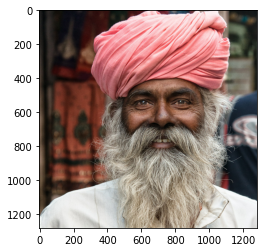

In [ ]:

# load the model
modl = model
testImage = PATH + 'testImages/man-613601_1280.jpg'
isExist = os.path.isfile(testImage)
print(isExist)
image_feature = extract_feat(testImage)
# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_image_caption])
max_length = 30

photo = image_feature

# generate description
description = generate_desc(modl, tokenizr, photo, max_length)
print("Predicted caption -> ", description)
print()
print('*********************************************************************')
x=plt.imread(testImage)
plt.imshow(x)
plt.show()
print()